# Import initial libraries 

In [37]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from sklearn.metrics import multilabel_confusion_matrix
from keras.optimizers import Adamax, Adagrad, RMSprop, Adam
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create MediaPipe Function for Detect Body

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections [FACEMESH_TESSELATION]
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) 
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=1)) 
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)) 
    
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)) 

# Test MediaPipe Function with real camera 

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Create Extract Function for Extract Feature

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Create Datasets

In [30]:
DATA_PATH_TRAIN = os.path.join('/TSL_Recognition-main/TSL10/90_10/Train_Data/')
actions = np.array(['Fine', 'Hello', 'Hungry', 'IAm', 'Like',
                    'Love', 'Sick', 'Sorry', 'Thanks', 'You'])
no_sequences_train = 90
sequence_length = 30

In [31]:
DATA_PATH_TEST = os.path.join('/TSL_Recognition-main/TSL10/90_10/Test_Data/')
actions = np.array(['Fine', 'Hello', 'Hungry', 'IAm', 'Like',
                    'Love', 'Sick', 'Sorry', 'Thanks', 'You'])
no_sequences_test = 10
sequence_length = 30

# Prepare Data for train and test

In [32]:
label_map = {label: num for num, label in enumerate(actions)}

sequences_train, labels_train = [], []
sequences_test, labels_test = [], []

def load_sequences(data_path, action, num_sequences):
    sequences = []
    labels = []
    for sequence in range(num_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
    return sequences, labels


In [33]:

for action in actions:
    seq, lbl = load_sequences(DATA_PATH_TRAIN, action, no_sequences_train)
    sequences_train.extend(seq)
    labels_train.extend(lbl)

In [34]:

for action in actions:
    seq, lbl = load_sequences(DATA_PATH_TEST, action, no_sequences_test)
    sequences_test.extend(seq)
    labels_test.extend(lbl)

In [35]:
X_train = np.array(sequences_train)
y_train = to_categorical(labels_train).astype(int)
X_test = np.array(sequences_test)
y_test = to_categorical(labels_test).astype(int)

In [36]:
X_train.shape

(900, 30, 1662)

# Train model

Train BiLSTM Model

In [14]:
# K-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True)

accuracy_scores = []
loss_scores = []
train_loss_scores = []
train_accuracy_scores = []

for train_index, test_index in skf.split(X_train, labels_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    model_BiLSTM = Sequential([
        Bidirectional(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662))),
        Dropout(0.1),
        Bidirectional(LSTM(128, return_sequences=True, activation='relu')),
        Dropout(0.1),
        Bidirectional(LSTM(64, return_sequences=False, activation='relu')),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(actions.shape[0], activation='softmax')
    ])

    model_BiLSTM.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    history = model_BiLSTM.fit(X_train_fold, y_train_fold, epochs=550, batch_size=512)

    _, accuracy = model_BiLSTM.evaluate(X_test_fold, y_test_fold)
    accuracy_scores.append(accuracy)
    loss_scores.append(history.history['loss'])
    train_loss_scores.append(history.history['loss'])
    train_accuracy_scores.append(history.history['categorical_accuracy'])

Epoch 1/550
2/2 [==============================] - 10s 605ms/step - loss: 2.3195 - categorical_accuracy: 0.0986
Epoch 2/550
2/2 [==============================] - 2s 584ms/step - loss: 2.3089 - categorical_accuracy: 0.0972
Epoch 3/550
2/2 [==============================] - 2s 549ms/step - loss: 2.3010 - categorical_accuracy: 0.1194
Epoch 4/550
2/2 [==============================] - 2s 575ms/step - loss: 2.2868 - categorical_accuracy: 0.1264
Epoch 5/550
2/2 [==============================] - 2s 553ms/step - loss: 2.3077 - categorical_accuracy: 0.1125
Epoch 6/550
2/2 [==============================] - 2s 591ms/step - loss: 2.2545 - categorical_accuracy: 0.1542
Epoch 7/550
2/2 [==============================] - 2s 550ms/step - loss: 2.2416 - categorical_accuracy: 0.1653
Epoch 8/550
2/2 [==============================] - 2s 594ms/step - loss: 2.2196 - categorical_accuracy: 0.1583
Epoch 9/550
2/2 [==============================] - 2s 566ms/step - loss: 2.2374 - categorical_accuracy: 0.1181


In [15]:
for fold, loss in enumerate(loss_scores):
    print(f"Loss for Fold {fold+1}: {loss[-1]}")

mean_loss = np.mean([loss[-1] for loss in loss_scores])
print("Mean loss:", mean_loss)

print("Accuracy scores for each fold:", accuracy_scores)
print("Mean accuracy:", np.mean(accuracy_scores))

Loss for Fold 1: 0.28239187598228455
Loss for Fold 2: 0.1690487265586853
Loss for Fold 3: 0.1345556229352951
Loss for Fold 4: 0.4169442057609558
Loss for Fold 5: 0.08979682624340057
Mean loss: 0.21854745149612426
Accuracy scores for each fold: [0.8888888955116272, 0.9277777671813965, 0.8888888955116272, 0.6944444179534912, 0.9111111164093018]
Mean accuracy: 0.8622222185134888


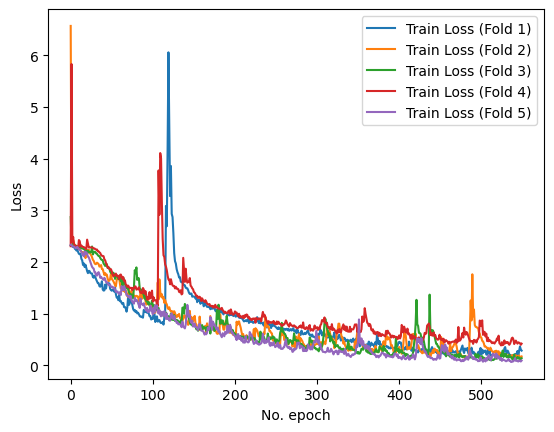

In [16]:
for fold, train_loss in enumerate(train_loss_scores):
    plt.plot(train_loss, label=f'Train Loss (Fold {fold+1})')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

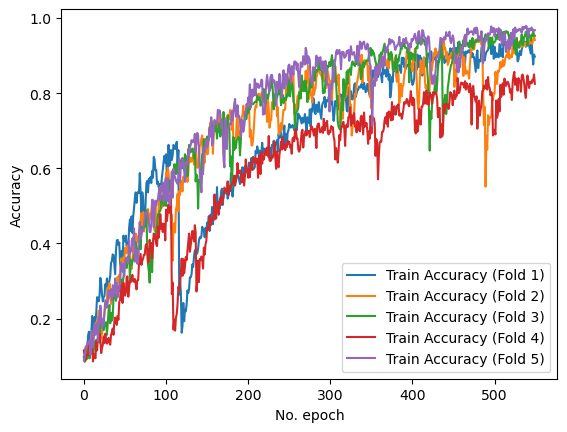

In [17]:
for fold, train_accuracy in enumerate(train_accuracy_scores):
    plt.plot(train_accuracy, label=f'Train Accuracy (Fold {fold+1})')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [ ]:
model_BiLSTM.summary()

In [18]:
model_BiLSTM.save('../BiLSTM/90/BiLSTM_Model_X.h5')

In [10]:
model_BiLSTM = load_model('./90/BiLSTM_Model.h5')

Test Accuracy Model

In [20]:
# y_pred = model_BiLSTM.predict(X_test)
# y_true = np.argmax(y_test, axis=1).tolist()
# y_pred = np.argmax(y_pred, axis=1).tolist()
# confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)

4/4 [==============================] - 2s 245ms/step


In [38]:
y_pred = model_BiLSTM.predict(X_test)
y_true = np.argmax(y_test, axis=1)

4/4 [==============================] - 0s 39ms/step


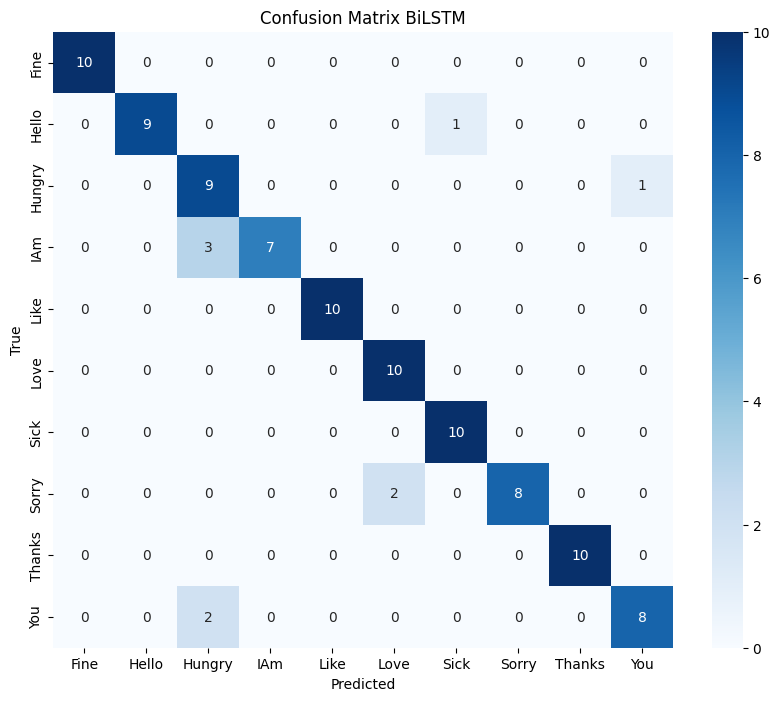

In [40]:
# สร้าง confusion matrix
conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# สร้าง heatmap ด้วย seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.title('Confusion Matrix BiLSTM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
accuracies = []
for i, matrix in enumerate(confusion_matrices):
    tn, fp, fn, tp = matrix.ravel()
    label_accuracy = (tp + tn) / (tp + tn + fp + fn)
    accuracies.append(label_accuracy)
    print(f"Label {i + 1} accuracy: {label_accuracy}")

overall_accuracy = np.mean(accuracies)
print(f"Mean Accuracy: {overall_accuracy}")

Label 1 accuracy: 1.0
Label 2 accuracy: 0.96
Label 3 accuracy: 0.96
Label 4 accuracy: 0.97
Label 5 accuracy: 0.97
Label 6 accuracy: 1.0
Label 7 accuracy: 0.99
Label 8 accuracy: 0.99
Label 9 accuracy: 0.99
Label 10 accuracy: 0.99
Mean Accuracy: 0.982


# Test Model in real time

In [ ]:
# # 1. New detection variables
# sequence = []
# sentence = []
# predictions = []
# confidence = 0.9

# cap = cv2.VideoCapture(0)

# # Set mediapipe model
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():

#         # Read feed
#         ret, frame = cap.read()

#         # Make detections
#         image, results = mediapipe_detection(frame, holistic)

#         # Draw landmarks
#         draw_styled_landmarks(image, results)

#         # 2. Prediction logic
#         keypoints = extract_keypoints(results)
#         sequence.append(keypoints)
#         sequence = sequence[-30:]

#         if len(sequence) == 30:
#             res = model_BiLSTM.predict(np.expand_dims(sequence, axis=0))[0]
#             predictions.append(np.argmax(res))

#         # 3. Viz logic
#             if np.unique(predictions[-10:])[0] == np.argmax(res):
#                 if res[np.argmax(res)] >= confidence:

#                     if len(sentence) > 0:
#                         if actions[np.argmax(res)] != sentence[-1]:
#                             sentence.append(actions[np.argmax(res)])
#                     else:
#                         sentence.append(actions[np.argmax(res)])

#             if len(sentence) > 1:
#                 sentence = sentence[-1:]

#         cv2.rectangle(image, (0, 0), (640, 40), (0, 204, 102), -1)
#         cv2.putText(image, ' '.join(sentence), (3, 30),
#                     cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

#         # Show to screen
#         cv2.imshow('Result', image)

#         # Break gracefully
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
#     cap.release()
#     cv2.destroyAllWindows()

In [29]:
sequence = []
sentence = []
predictions = []
confidence = 0.5

videos_path = '/TSL_Recognition-main/TSL10/For_Test/'
file_list = os.listdir(videos_path)
video_files = [file for file in file_list if file.endswith(('.avi', '.mp4', '.mov'))]

for video_file in video_files:
    video_path = os.path.join(videos_path, video_file)
    cap = cv2.VideoCapture(video_path)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, image = cap.read()
            if not ret:
                break

            frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = holistic.process(frame_rgb)
            draw_styled_landmarks(image, results)
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]

            if len(sequence) == 30:
                res = model_BiLSTM.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))

                if np.unique(predictions[-15:])[0] == np.argmax(res):
                    if res[np.argmax(res)] >= confidence:

                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 1:
                    sentence = sentence[-1:]
            
            print(sentence)
            cv2.rectangle(image, (0, 0), (640, 40), (0, 204, 102), -1)
            cv2.putText(image, ' '.join(sentence), (3, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.imshow('Video', image)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()

cv2.destroyAllWindows()

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
1/1 [==============================] - 0s 36ms/step
['Hungry']


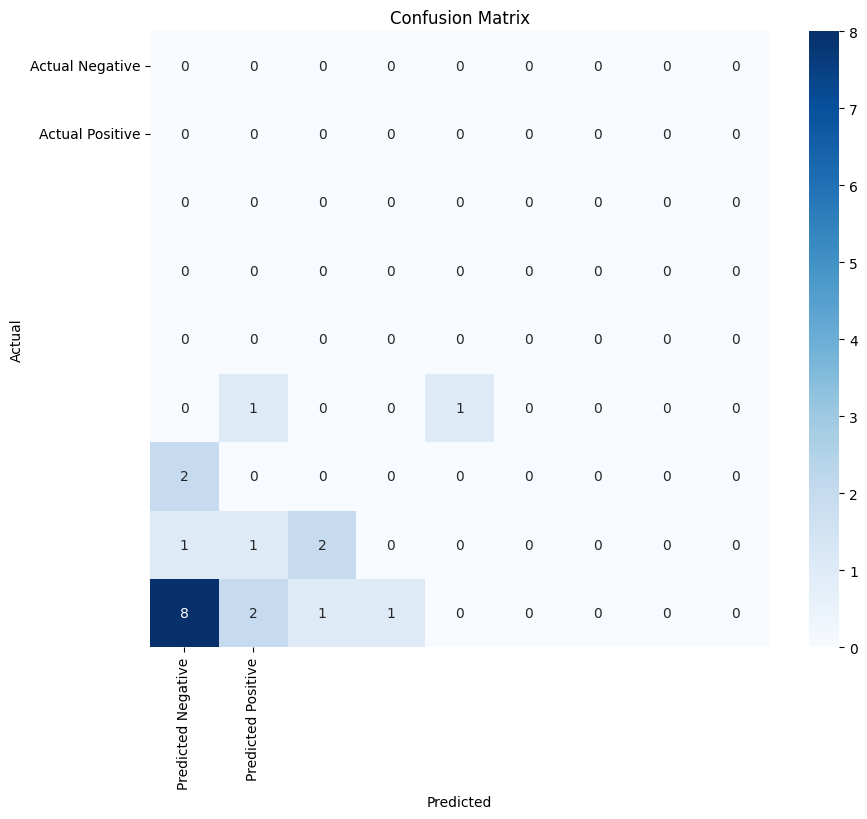

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Provided data
data = {
    "True Positive": [90, 90, 85, 90, 90, 88, 89, 90, 90, 89],
    "False Positive": [0, 0, 5, 0, 0, 0, 2, 1, 0, 1],
    "True Negative": [10, 9, 9, 7, 10, 10, 10, 8, 10, 8],
    "False Negative": [0, 1, 1, 3, 0, 0, 0, 2, 0, 2]
}

# Create DataFrame
labels = ["Fine", "Hello", "Hungry", "IAm", "Like", "Love", "Sick", "Sorry", "Thanks", "You"]

# สร้าง DataFrame
# df = pd.DataFrame(data, index=labels)

# คำนวณ Confusion Matrix
cm = confusion_matrix(data["True Positive"] + data["True Positive"] , data["False Positive"] + data["False Negative"])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()